# Relax Data Science Challenge

The  data  is  available  as  two  attached  CSV  files:

- takehome_user_engagement.csv
- takehome_users.csv

The  data  has  the  following  two  tables:

[1]  A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the
product  in  the  last  two  years.   This  table  includes:

● name:  the  user's  name

● object_id:   the  user's  id

● email:  email  address

● creation_source:   how  their  account  was  created.  This  takes  on  one of  5  values:
    
    ○ PERSONAL_PROJECTS:  invited  to  join  another  user's personal  workspace
    
    ○ GUEST_INVITE:  invited  to  an  organization  as  a  guest (limited  permissions)
    
    ○ ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
    
    ○ SIGNUP:  signed  up  via  the  website

    ○ SIGNUP_GOOGLE_AUTH:  signed  up  using  Google Authentication  (using  a  Google  email  account  for  their  login id)

● creation_time:  when  they  created  their  account

● last_session_creation_time:   unix  timestamp  of  last  login

● opted_in_to_mailing_list:  whether  they  have  opted  into  receiving marketing  emails

● enabled_for_marketing_drip:  whether  they  are  on  the  regular marketing  email  drip

● org_id:   the  organization  (group  of  users)  they  belong  to

● invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).


[2]  A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day
that  a  user  logged  into  the  product.
Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven-day  period ,  identify  which  factors  predict  future  user
adoption .

We  suggest  spending  1-2  hours  on  this,  but  you're  welcome  to  spend  more  or  less.
Please  send  us  a  brief  writeup  of  your  findings  (the  more  concise,  the  better  ­­  no  more
than  one  page),  along  with  any  summary  tables,  graphs,  code,  or  queries  that  can  help
us  understand  your  approach.  Please  note  any  factors  you  considered  or  investigation
you  did,  even  if  they  did  not  pan  out.  Feel  free  to  identify  any  further  research  or  data
you  think  would  be  valuable

### Data Insights from Analysis

- Major Assumption : In the user_engagement.csv data, there are 3177 missing users that are in users.csv file. For analysis purposes, we assumed these users to be "Not-Adopted"  

- As per the given data, we can see that Adoption Rate is only 13.35%

- From the initial look at the data, one can infer that below feature columns should have large impact on the adoption status of the users. 
    - Column names: creation_source , last_session_creation_time, opted_in_to_mailing_list, enabled_for_marketing_drip, org_id, and invited_by_user_id 
    
- However, we can see that from the correlation matrix and feature importances after XGBoost modeling that feature columns: last_session_creation_time, enabled_for_marketing_drip, and creation time had the largest impact on adoption status

- Business can also take into consideration the importance of order of creation_source (how the account was created) from highest adoption rate to lowest in following order: ORG_INVITE, GUEST_INVITE, SIGNUP, SIGNUP_GOOGLE_AUTH, PERSONAL_PROJECTS

- Only about 1% more Adopted users (Total = 25.84%) opted_in_to_mailing_list compared to Non-Adopted users (Total = 24.81%)

- From the histograms and correlation matrix, we can see that login_counts directly impact the adoption status of the user. Business should drive the user behavior towards more logins.

- More features such as demographics of users (age, location, gender, etc) can definitely help derive the business decisions in this setting.

### Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
import sklearn.metrics as m
import itertools

In [2]:
user_engagement_df = pd.read_csv("takehome_user_engagement.csv")
user_engagement_df[:10]

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1


In [3]:
users_df = pd.read_csv("takehome_users.csv", engine='python')
users_df[:10]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0


In [4]:
user_engagement_df.visited.value_counts()

1    207917
Name: visited, dtype: int64

In [5]:
list_user_ids = list(user_engagement_df.user_id.unique())
len(list_user_ids)

8823

In [6]:
userid_adopted_user_indicator_dict = {}
for user_id in list_user_ids:
    user_timestamp_list = user_engagement_df.time_stamp[user_engagement_df.user_id==user_id].to_list()
    
    if len(user_timestamp_list) >= 3:
        for i in range (len(user_timestamp_list)):
            
            start_timestamp = user_timestamp_list[i]
            end_timestamp = (datetime.strptime(start_timestamp, '%Y-%m-%d %H:%M:%S') + timedelta(days=6)).strftime('%Y-%m-%d %H:%M:%S')

            if ((user_timestamp_list[i+1] <= end_timestamp) & (user_timestamp_list[i+2] <= end_timestamp)):
                userid_adopted_user_indicator_dict[user_id] = 1
                break
                
            if (len(user_timestamp_list)-i-1) < 3:
                break  
                
    if user_id not in list(userid_adopted_user_indicator_dict.keys()):
        userid_adopted_user_indicator_dict[user_id] = 0
        
assert len(userid_adopted_user_indicator_dict)==len(user_engagement_df.user_id.unique()), "Created user adoption dictionary length does not macth total number of users"
print(userid_adopted_user_indicator_dict)

{1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 10: 1, 11: 0, 13: 0, 14: 0, 17: 0, 19: 0, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 1, 36: 0, 37: 0, 41: 0, 42: 1, 43: 1, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 1, 51: 0, 53: 1, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 63: 1, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 1, 72: 0, 73: 0, 74: 1, 75: 0, 76: 0, 77: 0, 78: 0, 80: 1, 81: 1, 82: 1, 83: 0, 84: 0, 85: 0, 86: 0, 87: 1, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 103: 0, 105: 0, 106: 0, 107: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 119: 0, 121: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 132: 0, 133: 1, 135: 1, 136: 0, 138: 0, 139: 0, 140: 0, 141: 1, 142: 0, 143: 0, 144: 0, 146: 1, 147: 0, 150: 0, 151: 0, 153: 1, 154: 0, 155: 0, 156: 0, 158: 0, 159: 0, 160: 1, 161: 0, 162: 0, 164: 0, 165: 1, 167: 0, 168: 1, 171: 0, 172: 1, 173: 0, 174: 1, 175: 0

In [7]:
print(len(userid_adopted_user_indicator_dict))

8823


In [8]:
# Creating dictionary of user_ids and login counts of the users
user_id_login_counts_dict = user_engagement_df.user_id.value_counts().to_dict()
len(user_id_login_counts_dict)

8823

### Now, lets look at the user_df dataset

In [9]:
print("Number of records in : ", len(users_df))
print("Number of unique object ids : ", len(users_df.object_id))

Number of records in :  12000
Number of unique object ids :  12000


- Login data is missing for (12000-8823) = 3177 users

### Adding a new feature column : login_counts of the users

In [10]:
users_df["login_counts"] = users_df['object_id'].map(user_id_login_counts_dict)
users_df[:10]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,login_counts
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,14.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,1.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,1.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,284.0


### Adding y_target column adopted_status to the users_df dataset 

In [11]:
users_df["adopted_status"] = users_df['object_id'].map(userid_adopted_user_indicator_dict)
users_df[:10]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,login_counts,adopted_status
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,14.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0,0.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,1.0,0.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,1.0,0.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,NaN,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,NaN,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,284.0,1.0


### Check for null values

In [12]:
users_df.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
login_counts                  3177
adopted_status                3177
dtype: int64

#### column = adopted_status

- Fill the missing adopted status with False=0

In [13]:
users_df.adopted_status.fillna(0, inplace=True)
users_df[:20]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,login_counts,adopted_status
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,14.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0,0.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,1.0,0.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,1.0,0.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,NaN,0.0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,NaN,0.0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,284.0,1.0


In [14]:
users_df.adopted_status.value_counts()

0.0    10398
1.0     1602
Name: adopted_status, dtype: int64

In [15]:
print("Current Adoption Rate : ", users_df.adopted_status.value_counts().get(1)/len(users_df)*100)

Current Adoption Rate :  13.350000000000001


- As we can see, the current adoption rate is only 13.35% as per this dataset

Text(0, 0.5, 'Counts')

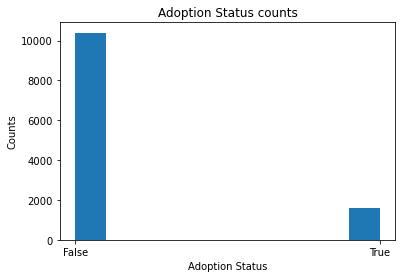

In [16]:
plt.hist(users_df.adopted_status)
plt.title("Adoption Status counts")
plt.xticks([0,1],["False","True"])
plt.xlabel("Adoption Status")
plt.ylabel("Counts")

#### column = login_counts

In [17]:
# filling null with login_counts =1 assuming missing users only logged in during the creation time
users_df.login_counts.fillna(1, inplace=True)

In [18]:
users_df[:10]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,login_counts,adopted_status
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,14.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0,0.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,1.0,0.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,1.0,0.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,1.0,0.0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,1.0,0.0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,284.0,1.0


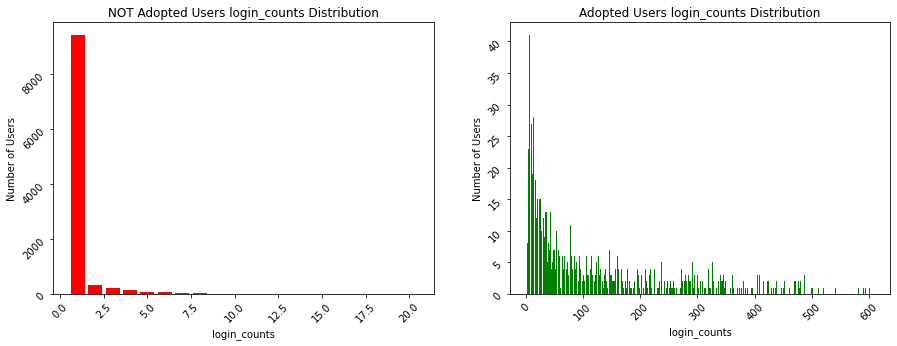

In [19]:
import matplotlib.pylab as pylab
i = 0
titles = ["NOT Adopted Users login_counts Distribution", "Adopted Users login_counts Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for adoption_status_value in [0,1]:
    axs[i].tick_params(labelrotation=45)
    x = users_df.login_counts[users_df.adopted_status==adoption_status_value].value_counts().keys().to_list()
    y = users_df.login_counts[users_df.adopted_status==adoption_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='login_counts', ylabel='Number of Users')
    i += 1

#### column = last_session_creation_time 

- filling the missing last_session_creation_time values with creation time

In [20]:
users_df['last_session_creation_time'][:1]

0    1.398139e+09
Name: last_session_creation_time, dtype: float64

In [21]:
# Assigning all null values in the last_session_creation_time column tovalues from creation_time
users_df.loc[users_df.last_session_creation_time.isnull(), 'last_session_creation_time'] = users_df.loc[users_df.last_session_creation_time.isnull(), "creation_time"]
users_df[:10]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,login_counts,adopted_status
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.39814e+09,1,0,11,10803.0,1.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.39624e+09,0,0,1,316.0,14.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.36373e+09,0,0,94,1525.0,1.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.36921e+09,0,0,1,5151.0,1.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.35885e+09,0,0,193,5240.0,1.0,0.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.38742e+09,0,0,197,11241.0,1.0,0.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.35601e+09,0,1,37,NaN,1.0,0.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,2013-07-31 05:34:02,1,1,74,NaN,1.0,0.0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,2013-11-05 04:04:24,0,0,302,NaN,1.0,0.0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.40183e+09,1,1,318,4143.0,284.0,1.0


In [22]:
def convert_to_datetime(series):
    for time in series:
        try:
            yield datetime.fromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S')
        except:
            yield time

In [23]:
#  Converting all last_session_creation_time to datetime format for more readable data
users_df["last_session_creation_time"] = list(convert_to_datetime(list(users_df.last_session_creation_time)))
users_df[:10]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,login_counts,adopted_status
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 04:53:30,1,0,11,10803.0,1.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 04:45:04,0,0,1,316.0,14.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-20 00:14:52,0,0,94,1525.0,1.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 09:09:28,0,0,1,5151.0,1.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1.0,0.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241.0,1.0,0.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN,1.0,0.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,2013-07-31 05:34:02,1,1,74,NaN,1.0,0.0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,2013-11-05 04:04:24,0,0,302,NaN,1.0,0.0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 23:08:03,1,1,318,4143.0,284.0,1.0


#### column = invited_by_user_id
- filling Null values in this column with Unknown=0

In [24]:
users_df.invited_by_user_id.fillna(0, inplace=True)
users_df[:10]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,login_counts,adopted_status
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 04:53:30,1,0,11,10803.0,1.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 04:45:04,0,0,1,316.0,14.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-20 00:14:52,0,0,94,1525.0,1.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 09:09:28,0,0,1,5151.0,1.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1.0,0.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241.0,1.0,0.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,0.0,1.0,0.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,2013-07-31 05:34:02,1,1,74,0.0,1.0,0.0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,2013-11-05 04:04:24,0,0,302,0.0,1.0,0.0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 23:08:03,1,1,318,4143.0,284.0,1.0


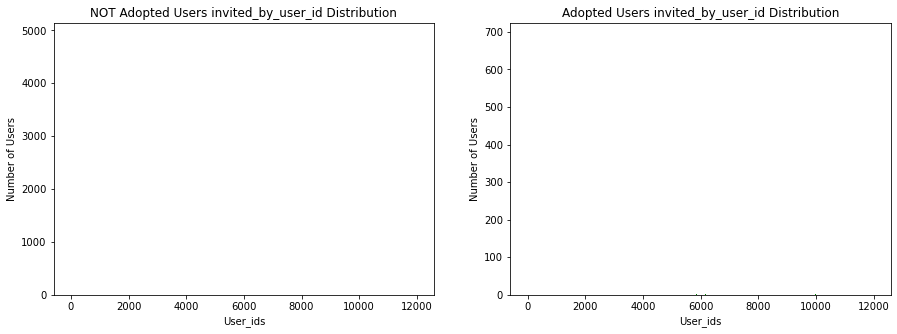

In [25]:
import matplotlib.pylab as pylab
i = 0
titles = ["NOT Adopted Users invited_by_user_id Distribution", "Adopted Users invited_by_user_id Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for adoption_status_value in [0,1]:
    x = users_df.invited_by_user_id[users_df.adopted_status==adoption_status_value].value_counts().keys().to_list()
    y = users_df.invited_by_user_id[users_df.adopted_status==adoption_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='User_ids', ylabel='Number of Users')
    i += 1

#### column  = creation_source

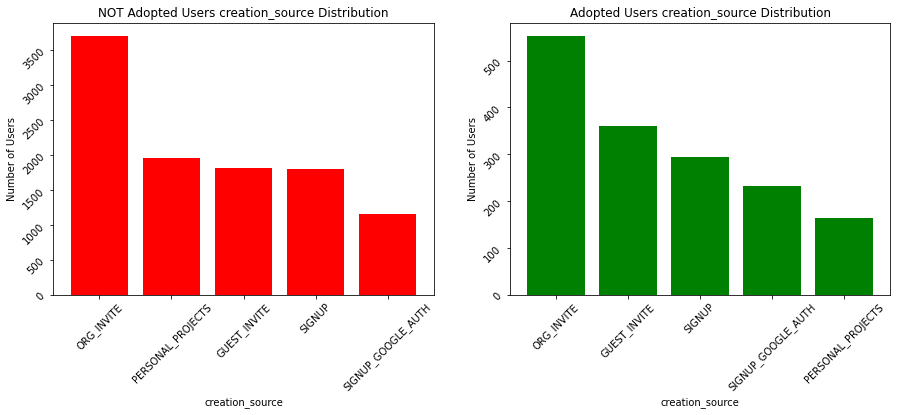

In [26]:
import matplotlib.pylab as pylab
i = 0
titles = ["NOT Adopted Users creation_source Distribution", "Adopted Users creation_source Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for adoption_status_value in [0,1]:
    axs[i].tick_params(labelrotation=45)
    x = users_df.creation_source[users_df.adopted_status==adoption_status_value].value_counts().keys().to_list()
    y = users_df.creation_source[users_df.adopted_status==adoption_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='creation_source', ylabel='Number of Users')
    i += 1

#### column = opted_in_to_mailing_list

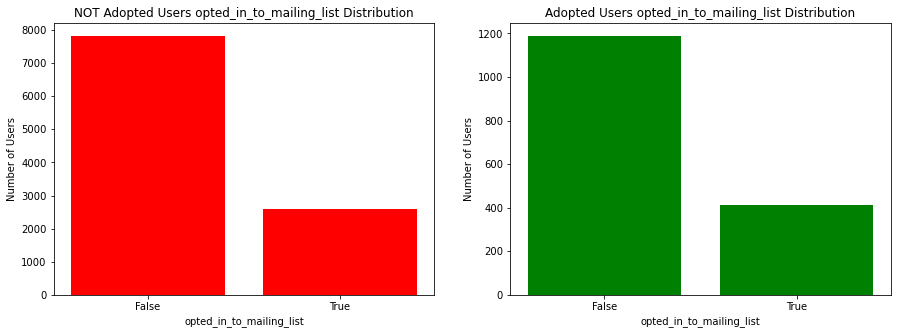

In [27]:
import matplotlib.pylab as pylab
i = 0
titles = ["NOT Adopted Users opted_in_to_mailing_list Distribution", "Adopted Users opted_in_to_mailing_list Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.setp(axs, xticks=[0,1], xticklabels=["False","True"])
for adoption_status_value in [0,1]:
    x = users_df.opted_in_to_mailing_list[users_df.adopted_status==adoption_status_value].value_counts().keys().to_list()
    y = users_df.opted_in_to_mailing_list[users_df.adopted_status==adoption_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='opted_in_to_mailing_list', ylabel='Number of Users')
    i += 1

In [28]:
print("% of Not-Adopted users opted_in_to_mailing_list : ", users_df.opted_in_to_mailing_list[users_df.adopted_status==0].value_counts().get(1)/len(users_df.opted_in_to_mailing_list[users_df.adopted_status==0]) *100)
print("% of Adopted users opted_in_to_mailing_list : ", users_df.opted_in_to_mailing_list[users_df.adopted_status==1].value_counts().get(1)/len(users_df.opted_in_to_mailing_list[users_df.adopted_status==1]) *100)

% of Not-Adopted users opted_in_to_mailing_list :  24.812463935372186
% of Adopted users opted_in_to_mailing_list :  25.842696629213485


#### column = enabled_for_marketing_drip

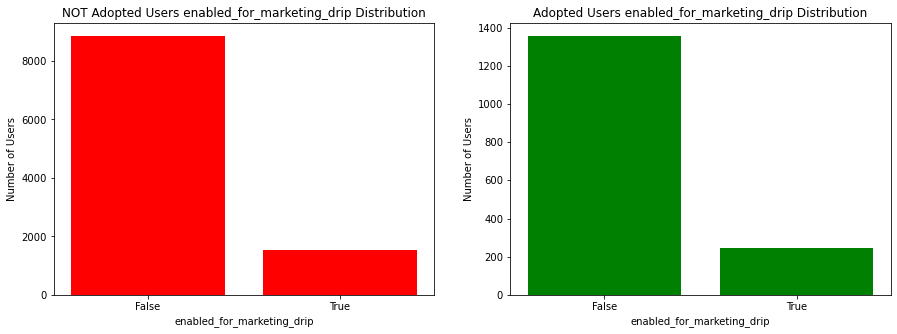

In [29]:
import matplotlib.pylab as pylab
i = 0
titles = ["NOT Adopted Users enabled_for_marketing_drip Distribution", "Adopted Users enabled_for_marketing_drip Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.setp(axs, xticks=[0,1], xticklabels=["False","True"])
for adoption_status_value in [0,1]:
    x = users_df.enabled_for_marketing_drip[users_df.adopted_status==adoption_status_value].value_counts().keys().to_list()
    y = users_df.enabled_for_marketing_drip[users_df.adopted_status==adoption_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='enabled_for_marketing_drip', ylabel='Number of Users')
    i += 1

In [30]:
print("% of Not-Adopted users enabled_for_marketing_drip : ", users_df.enabled_for_marketing_drip[users_df.adopted_status==0].value_counts().get(1)/len(users_df.enabled_for_marketing_drip[users_df.adopted_status==0]) *100)
print("% of Adopted users enabled_for_marketing_drip : ", users_df.enabled_for_marketing_drip[users_df.adopted_status==1].value_counts().get(1)/len(users_df.enabled_for_marketing_drip[users_df.adopted_status==1]) *100)

% of Not-Adopted users enabled_for_marketing_drip :  14.868243893056357
% of Adopted users enabled_for_marketing_drip :  15.355805243445692


#### column = org_id

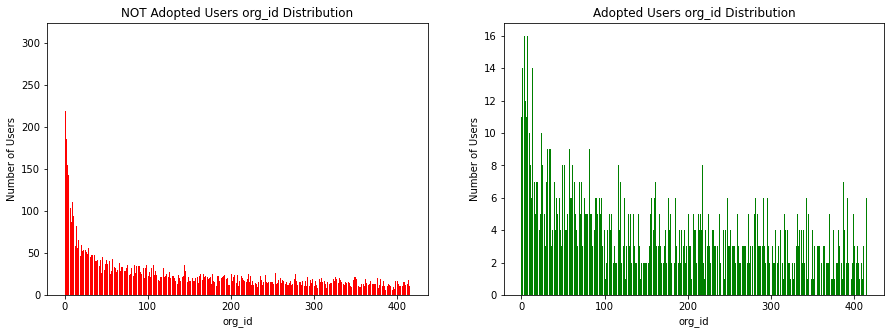

In [31]:
import matplotlib.pylab as pylab
i = 0
titles = ["NOT Adopted Users org_id Distribution", "Adopted Users org_id Distribution"]
colors = ["red", "green"]
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for adoption_status_value in [0,1]:
    x = users_df.org_id[users_df.adopted_status==adoption_status_value].value_counts().keys().to_list()
    y = users_df.org_id[users_df.adopted_status==adoption_status_value].value_counts().to_list()
    axs[i].bar(x, y, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set(xlabel='org_id', ylabel='Number of Users')
    i += 1

### Transforming non-numerical columns to labeled encoders

In [32]:
# Since a lot of data is in the String format which we can not feed to classifier, 
# we will encode the column values to labeled integer values
# We only encode the non-integer type of columns
columns_to_encode = users_df.select_dtypes(include=[object]).columns.tolist()
print(columns_to_encode)

#Labeled Encoder
le = preprocessing.LabelEncoder()
le_mapping_last_trip_date = []
for column_name in columns_to_encode:
    users_df[column_name] = le.fit_transform(users_df[column_name])

['creation_time', 'name', 'email', 'creation_source', 'last_session_creation_time']


In [33]:
users_df[:5]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,login_counts,adopted_status
0,1,10807,2087,1047,0,9407,1,0,11,10803.0,1.0,0.0
1,2,7647,8488,7290,1,8919,0,0,1,316.0,14.0,1.0
2,3,3939,1259,7681,1,3338,0,0,94,1525.0,1.0,0.0
3,4,4845,2099,7971,0,4172,0,0,1,5151.0,1.0,0.0
4,5,3018,8708,3718,0,2602,0,0,193,5240.0,1.0,0.0


### Correlation Matrix

In [34]:
params = {'figure.figsize': (15, 10),
         'xtick.labelsize':15,
         'ytick.labelsize':15}
pylab.rcParams.update(params)

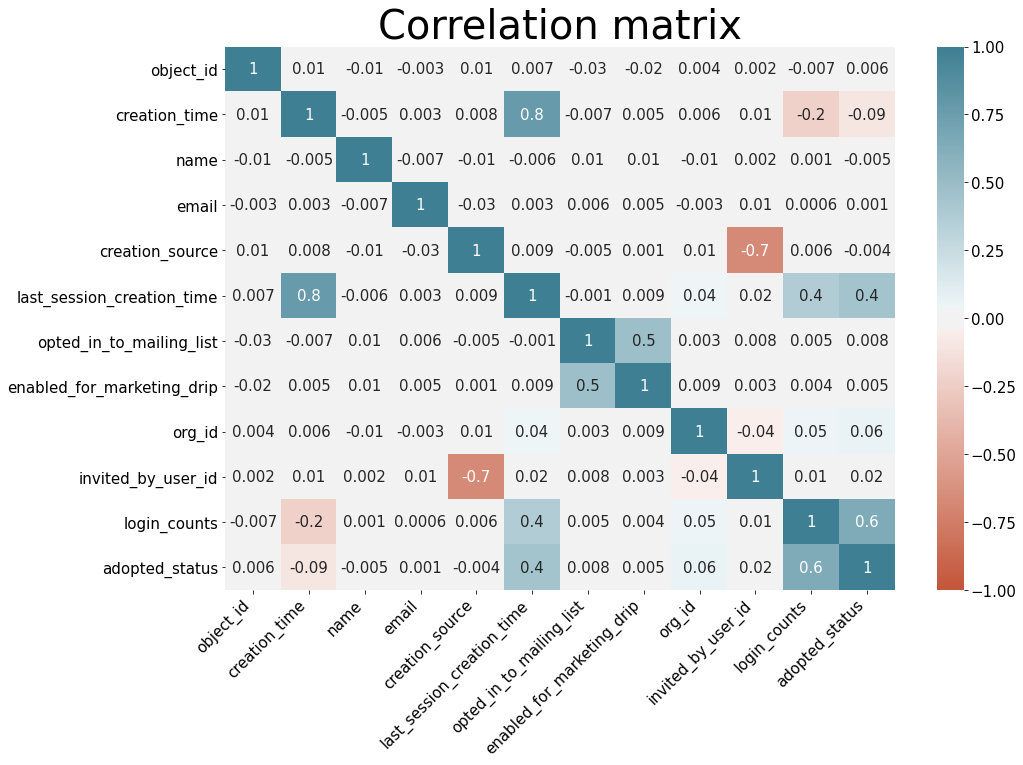

In [35]:
corr_matrix = users_df.corr()
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=256),
    fmt='.1g',
    annot=True,
    annot_kws={"size": 15}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title("Correlation matrix", fontsize = 40)
plt.show()

### Balacing the dataset for y_target column "adopted_status" for modeling

In [36]:
# Get the counts of binary values in the active_status column
users_df.adopted_status.value_counts()

0.0    10398
1.0     1602
Name: adopted_status, dtype: int64

In [37]:
# Calculating number of records to remove
false_counts_adopted_status = users_df.adopted_status.value_counts().get(0)
true_counts_adopted_status = users_df.adopted_status.value_counts().get(1)
remove_n = false_counts_adopted_status - true_counts_adopted_status
print("\nNumber of extra false records to remove :",remove_n)

# finding indices of the records we need to remove
indices_false_records = users_df.index[users_df.adopted_status==0]
print("\nVerifying total number of false records in dataframe : ", len(indices_false_records))
print(indices_false_records)

drop_indices = np.random.choice(indices_false_records, remove_n, replace=False)
print("\nVerifying # of records being removed : ", len(drop_indices))
print(drop_indices)

users_df = users_df.drop(drop_indices)
print("\nNumber of remaining total records in the dataframe : ", len(users_df))
users_df[:5]


Number of extra false records to remove : 8796

Verifying total number of false records in dataframe :  10398
Int64Index([    0,     2,     3,     4,     5,     6,     7,     8,    10,
               11,
            ...
            11990, 11991, 11992, 11993, 11994, 11995, 11996, 11997, 11998,
            11999],
           dtype='int64', length=10398)

Verifying # of records being removed :  8796
[ 1982   607 11524 ...  8207   358  4245]

Number of remaining total records in the dataframe :  3204


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,login_counts,adopted_status
1,2,7647,8488,7290,1,8919,0,0,1,316.0,14.0,1.0
9,10,3015,9263,1680,1,11608,1,1,318,4143.0,284.0,1.0
17,18,6294,4272,1774,0,5466,0,0,2,3153.0,1.0,0.0
19,20,9709,4651,11308,3,11035,0,0,58,0.0,7.0,1.0
21,22,9225,7545,4967,1,8026,0,0,7,2994.0,1.0,0.0


### Splitting the datasets into Train, Validation, Test

In [47]:
users_df_X_columns = users_df.columns.to_list()
users_df_X_columns.remove("adopted_status")
# removing login_counts feature as well since adopted_status column was calculated from login_counts as well.
# Therefore, we already know, login_counts column will have big impact on adopted_status results
users_df_X_columns.remove("login_counts")
print(users_df_X_columns)

['object_id', 'creation_time', 'name', 'email', 'creation_source', 'last_session_creation_time', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']


In [48]:
X = users_df[users_df_X_columns].to_numpy()
y = users_df["adopted_status"].to_numpy()

In [49]:
print("X shape : ",X.shape)
print("y shape : ",y.shape)

X shape :  (3204, 10)
y shape :  (3204,)


In [50]:
# Splitting the dataset for train and test
X, X_test, y, y_test = train_test_split(X, y, test_size=0.10)
print("X shape : ",X.shape)
print("y shape : ",y.shape)
print("X_test shape : ",X_test.shape)
print("y_test shape : ",y_test.shape)

X shape :  (2883, 10)
y shape :  (2883,)
X_test shape :  (321, 10)
y_test shape :  (321,)


In [51]:
# Further splitting for train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)

In [52]:
print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("X_valid shape : ", X_valid.shape)
print("y_valid shape : ", y_valid.shape)

X_train shape :  (2306, 10)
y_train shape :  (2306,)
X_valid shape :  (577, 10)
y_valid shape :  (577,)


### Modeling with XGBoost

In [53]:
xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_valid)
print("\nClassification Report \n{}".format(classification_report(y_valid, y_pred, target_names=['Not-Adopted 0', 'Adopted 1'])))
y_test_pred = xgb_model.predict(X_test)
print("Accuracy score for Test dataset : {}".format(accuracy_score(y_test, y_test_pred)))


Classification Report 
               precision    recall  f1-score   support

Not-Adopted 0       0.95      0.97      0.96       296
    Adopted 1       0.97      0.95      0.96       281

     accuracy                           0.96       577
    macro avg       0.96      0.96      0.96       577
 weighted avg       0.96      0.96      0.96       577

Accuracy score for Test dataset : 0.956386292834891


In [54]:
params = {'figure.figsize': (10, 5),
         'xtick.labelsize':15,
         'ytick.labelsize':15}
pylab.rcParams.update(params)


Confusion matrix


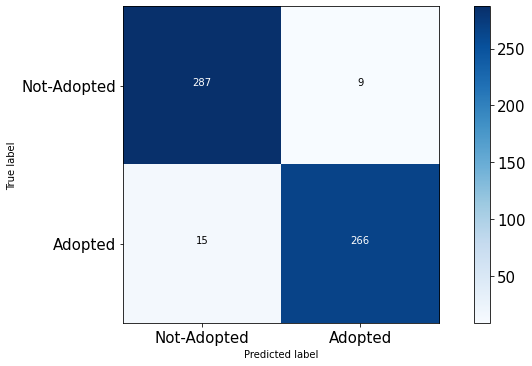

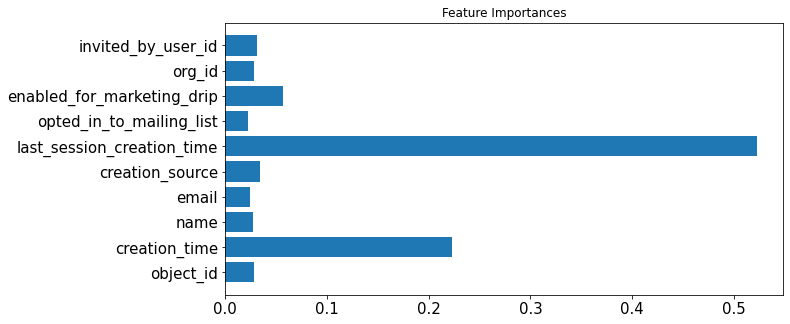

In [55]:
print("\nConfusion matrix")
conf_matrix = confusion_matrix(y_valid, y_pred)
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
tick_marks = np.arange(2)   
classes = ["Not-Adopted","Adopted"]
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
thresho = conf_matrix.max() / 2.
# The below for loop helps to add numbers in the boxes
for k, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, k, conf_matrix[k, j], horizontalalignment="center", color="white" if conf_matrix[k, j] > thresho else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()
plt.close()

feat_importances = xgb_model.feature_importances_
plt.title("Feature Importances")
plt.barh(range(len(feat_importances)), feat_importances)
plt.yticks(ticks=np.arange(0,len(users_df_X_columns)), labels=users_df_X_columns)
plt.show()
plt.close()